In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load the dataset

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 100s 1us/step


In [4]:
# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# 2. Explore the dataset


In [5]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])
print("Image dimensions:", X_train.shape[1:])

# Check data type and range
print("\nData type:", X_train.dtype)
print("Min pixel value:", X_train.min())
print("Max pixel value:", X_train.max())

# Class distribution
print("\nClass distribution (training set):")
unique, counts = np.unique(y_train, return_counts=True)
distribution = dict(zip(unique, counts))
for class_idx, count in distribution.items():
    print(f"{class_names[int(class_idx)]}: {count} samples ({count/len(y_train)*100:.2f}%)")

# Check for missing values
print("\nMissing values in training set:", np.isnan(X_train).sum())
print("Missing values in test set:", np.isnan(X_test).sum())

Training data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Number of training samples: 50000
Number of test samples: 10000
Image dimensions: (32, 32, 3)

Data type: uint8
Min pixel value: 0
Max pixel value: 255

Class distribution (training set):
airplane: 5000 samples (10.00%)
automobile: 5000 samples (10.00%)
bird: 5000 samples (10.00%)
cat: 5000 samples (10.00%)
deer: 5000 samples (10.00%)
dog: 5000 samples (10.00%)
frog: 5000 samples (10.00%)
horse: 5000 samples (10.00%)
ship: 5000 samples (10.00%)
truck: 5000 samples (10.00%)

Missing values in training set: 0
Missing values in test set: 0


# 3. Visualize sample images

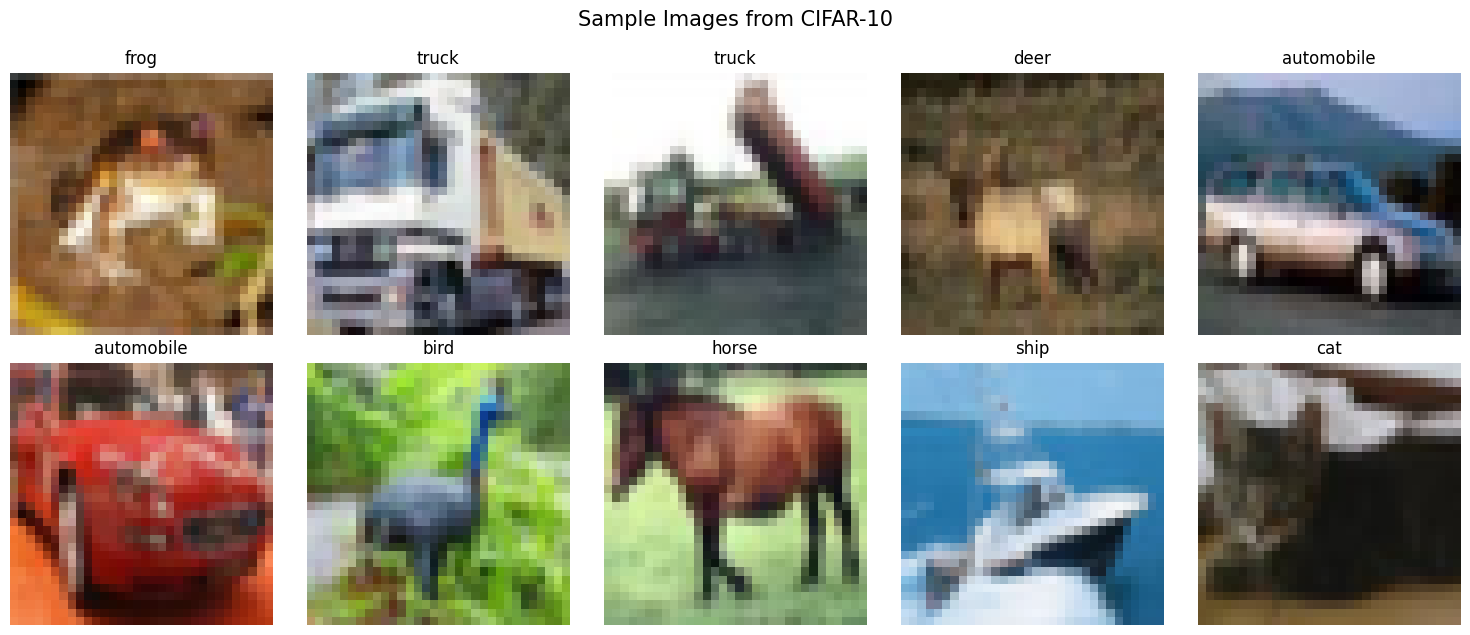

In [6]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample Images from CIFAR-10', y=1.05, fontsize=15)
plt.show()

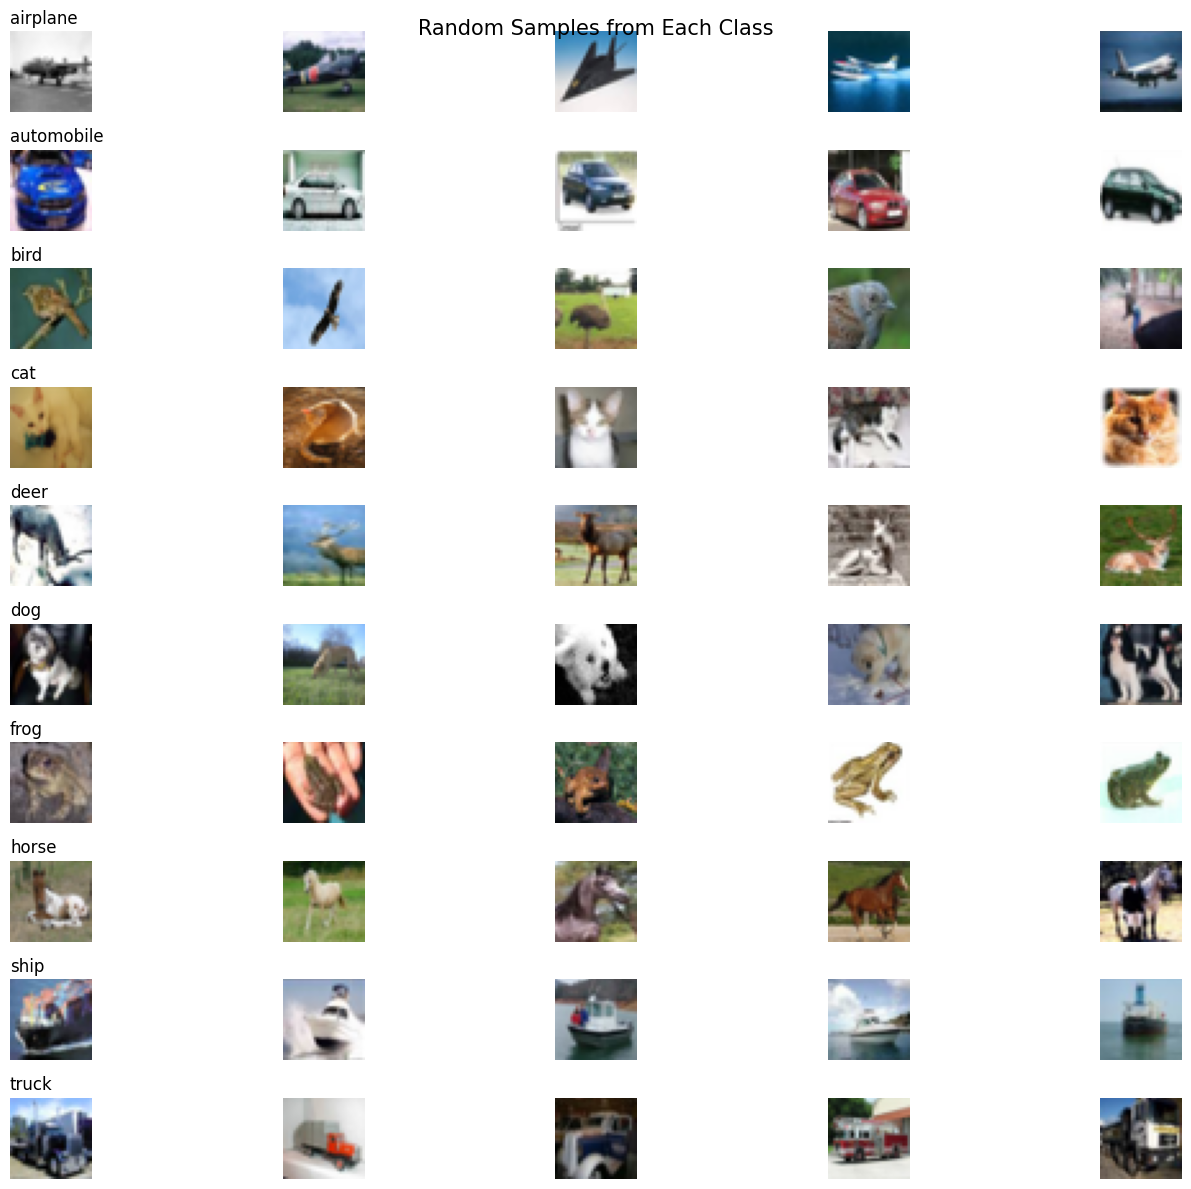

In [7]:
plt.figure(figsize=(15, 12))
for class_idx in range(10):
    # Find samples of this class
    indices = np.where(y_train == class_idx)[0]
    # Select 5 random samples
    random_indices = np.random.choice(indices, 5, replace=False)
    
    for i, idx in enumerate(random_indices):
        plt.subplot(10, 5, class_idx*5 + i + 1)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(class_names[class_idx], loc='left')
plt.tight_layout()
plt.suptitle('Random Samples from Each Class', y=0.98, fontsize=15)
plt.show()

# 4. Data preprocessing

In [8]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
print("Pixel values normalized to range [0, 1]")

# Reshape the target data to be 1D arrays
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)
print("Labels converted to one-hot encoding")

Pixel values normalized to range [0, 1]
Labels converted to one-hot encoding


In [9]:
# Create a validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.1, random_state=42)

print("Validation set created")
print("Final training set size:", X_train_final.shape[0])
print("Validation set size:", X_val.shape[0])

Validation set created
Final training set size: 45000
Validation set size: 5000


# 6. Build a simple CNN model

In [11]:
def build_simple_cnn():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:
simple_model = build_simple_cnn()

In [13]:
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,858 (4.77 MB)

 Trainable params: 1,250,858 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train the simple model

In [15]:
# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_simple_cnn.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history_simple = simple_model.fit(
    X_train_final, y_train_final,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3293 - loss: 1.8032
Epoch 1: val_accuracy improved from -inf to 0.56940, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.3294 - loss: 1.8029 - val_accuracy: 0.5694 - val_loss: 1.1934 - learning_rate: 0.0010
Epoch 2/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5756 - loss: 1.1906
Epoch 2: val_accuracy improved from 0.56940 to 0.67020, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.5757 - loss: 1.1904 - val_accuracy: 0.6702 - val_loss: 0.9240 - learning_rate: 0.0010
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6460 - loss: 0.9908
Epoch 3: val_accuracy improved from 0.67020 to 0.70200, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.6461 - loss: 0.9907 - val_accuracy: 0.7020 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6881 - loss: 0.8790
Epoch 4: val_accuracy improved from 0.70200 to 0.72520, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6881 - loss: 0.8790 - val_accuracy: 0.7252 - val_loss: 0.7679 - learning_rate: 0.0010
Epoch 5/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7182 - loss: 0.7975
Epoch 5: val_accuracy improved from 0.72520 to 0.74420, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.7182 - loss: 0.7975 - val_accuracy: 0.7442 - val_loss: 0.7379 - learning_rate: 0.0010
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7376 - loss: 0.7496
Epoch 6: val_accuracy improved from 0.74420 to 0.74860, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.7376 - loss: 0.7495 - val_accuracy: 0.7486 - val_loss: 0.7416 - learning_rate: 0.0010
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7491 - loss: 0.7077
Epoch 7: val_accuracy improved from 0.74860 to 0.76980, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7491 - loss: 0.7077 - val_accuracy: 0.7698 - val_loss: 0.6684 - learning_rate: 0.0010
Epoch 8/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7655 - loss: 0.6604
Epoch 8: val_accuracy improved from 0.76980 to 0.77160, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.7655 - loss: 0.6604 - val_accuracy: 0.7716 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 9/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7799 - loss: 0.6289
Epoch 9: val_accuracy did not improve from 0.77160
704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.7799 - loss: 0.6288 - val_accuracy: 0.7674 - val_loss: 0.6770 - learning_rate: 0.0010
Epoch 10/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7891 - loss: 0.6018
Epoch 10: val_accuracy improved from 0.77160 to 0.77300, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.7891 - loss: 0.6017 - val_accuracy: 0.7730 - val_loss: 0.6553 - learning_rate: 0.0010
Epoch 11/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7961 - loss: 0.5827
Epoch 11: val_accuracy improved from 0.77300 to 0.77380, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.7962 - loss: 0.5826 - val_accuracy: 0.7738 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 12/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8026 - loss: 0.5560
Epoch 12: val_accuracy improved from 0.77380 to 0.78240, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.8026 - loss: 0.5560 - val_accuracy: 0.7824 - val_loss: 0.6437 - learning_rate: 0.0010
Epoch 13/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8098 - loss: 0.5371
Epoch 13: val_accuracy did not improve from 0.78240
704/704 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.8098 - loss: 0.5371 - val_accuracy: 0.7710 - val_loss: 0.6621 - learning_rate: 0.0010
Epoch 14/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8165 - loss: 0.5089
Epoch 14: val_accuracy did not improve from 0.78240
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8165 - loss: 0.5088 - val_accuracy: 0.7786 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 15/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8244 - loss: 0.4977
Epoch 15: val_accuracy did not improve from 0.78240
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8244 - loss: 0.4977 - val_accuracy: 0.7818 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 16

704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.8382 - loss: 0.4531 - val_accuracy: 0.7842 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 19/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8409 - loss: 0.4439
Epoch 19: val_accuracy improved from 0.78420 to 0.79160, saving model to best_simple_cnn.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8409 - loss: 0.4439 - val_accuracy: 0.7916 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 20/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8446 - loss: 0.4295
Epoch 20: val_accuracy did not improve from 0.79160
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.8446 - loss: 0.4295 - val_accuracy: 0.7906 - val_loss: 0.6171 - learning_rate: 0.0010


# 8. Evaluate the simple model

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7893 - loss: 0.6326
Test accuracy: 0.7880
Test loss: 0.6481


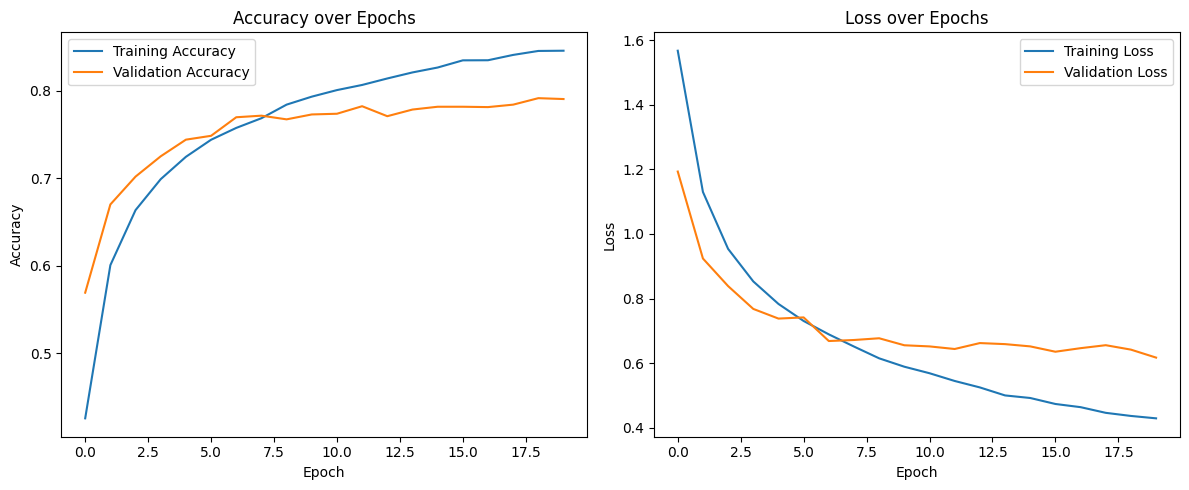

In [16]:
# Evaluate on the test set
test_loss, test_acc = simple_model.evaluate(X_test, y_test_onehot, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Training Accuracy')
plt.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Training Loss')
plt.plot(history_simple.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Make predictions and analyze results

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


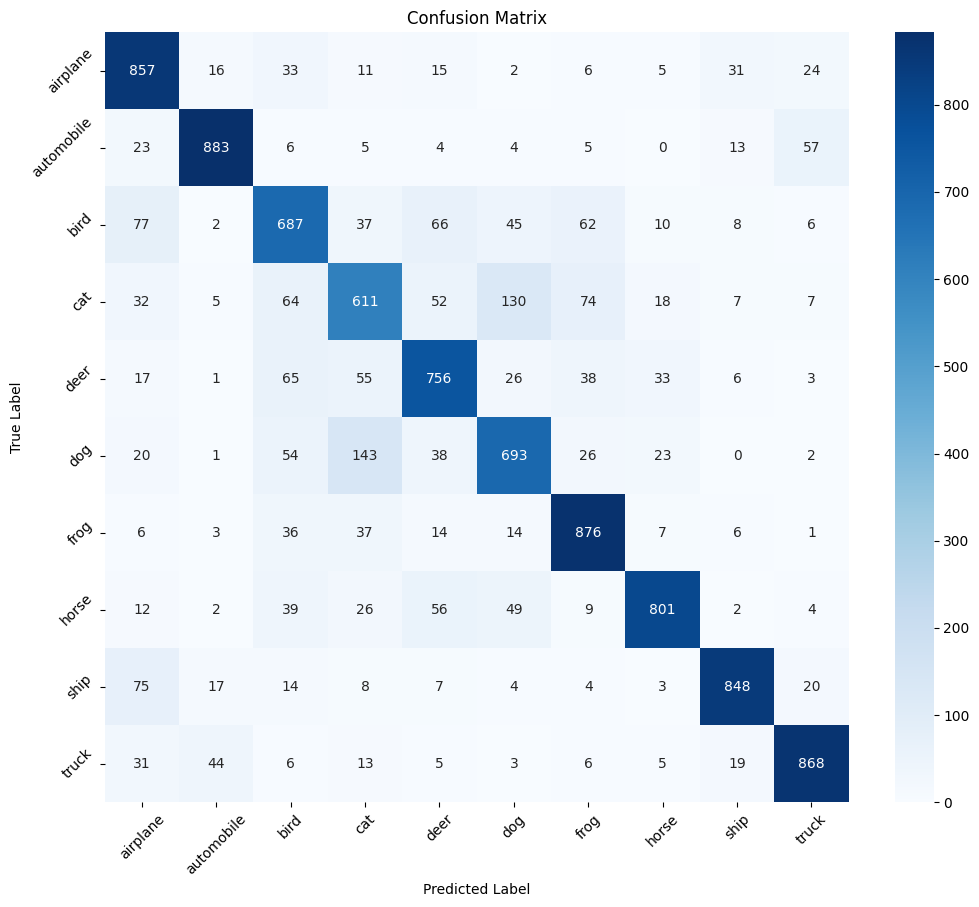


Classification Report:
              precision    recall  f1-score   support

    airplane       0.75      0.86      0.80      1000
  automobile       0.91      0.88      0.89      1000
        bird       0.68      0.69      0.69      1000
         cat       0.65      0.61      0.63      1000
        deer       0.75      0.76      0.75      1000
         dog       0.71      0.69      0.70      1000
        frog       0.79      0.88      0.83      1000
       horse       0.89      0.80      0.84      1000
        ship       0.90      0.85      0.87      1000
       truck       0.88      0.87      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [17]:
# Get predictions
y_pred_prob = simple_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 10. Summary

- My simple CNN model achieved 78.8% accuracy on the test set, which is a respectable baseline for this challenging dataset
- The model showed varying performance across different classes:
  - Best performance on vehicles: automobiles (88% accuracy) and ships (85% accuracy)
  - Worst performance on animals: cats (61% accuracy) and birds (69% accuracy)
- The confusion matrix revealed that the model frequently confused visually similar classes (e.g., cats and dogs, birds and deer)
- Training showed signs of overfitting after ~12 epochs, with the validation accuracy plateauing while training accuracy continued to improve

#### What I Learned
- Deep learning models require careful balancing of model capacity and regularization techniques
- Image classification performance varies significantly across classes, often correlating with visual distinctiveness
- The gap between training and validation metrics provides valuable insights into model generalization
- CNN architectures effectively capture hierarchical patterns in image data, with earlier layers detecting simple features (edges, textures) and deeper layers identifying more complex structures
- For real-world applications, more sophisticated architectures, data augmentation, and longer training would likely be necessary to achieve better performance
